## CORDIC Testbench


This notebook is to test the implementation of a CORDIC running on the programmable logic. The CORDIC is used to convert cartesian to polar coordinates. The output is compared with a Python calculation of the coordinate transform. It takes in x and y and gives out r and theta where r is the radius and theta is the angle.

In [1]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
import binascii
import cmath
import random
import matplotlib.pyplot as plt

NUM_SAMPLES = 50

In [2]:
ol=Overlay('./cordic.bit') #Change name of bitstream as required

In [3]:
cordic_ip = MMIO(0x40000000, 0x10000) #Change base address as required

In [4]:
r_error=np.zeros(NUM_SAMPLES)
theta_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
r_rmse=np.zeros(NUM_SAMPLES)
theta_rmse=np.zeros(NUM_SAMPLES)

In [5]:
for i in range(NUM_SAMPLES):
    #Generating random inputs
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    
    #Computing golden output
    cn=complex(x,y)
    cn=cmath.polar(cn)
    
    #Converting input to bytes to be sent to FPGA
    x=(struct.unpack('<I', struct.pack('<f', x))[0])
    y=(struct.unpack('<I', struct.pack('<f', y))[0])
    
    #Writing values to the FPGA
    cordic_ip.write(0x10,x)                             #Change the offset as mentioned in vivado file
    cordic_ip.write(0x18,y)                             #Change the offset as mentioned in vivado file
    
    #Starting and stopping the IP (Don't change this)
    cordic_ip.write(0x00,1)
    cordic_ip.write(0x00,0)
    
    #Reading from IP
    r=hex(cordic_ip.read(0x20))                         #Change the offset as mentioned in vivado file
    r=r[2:]
    theta=hex(cordic_ip.read(0x30))                     #Change the offset as mentioned in vivado file
    theta=theta[2:]
    
    #Converting to float
    if r!=0:
        r=struct.unpack('>f', binascii.unhexlify(r))
        r=r[0]
    if theta!=0:
        theta=struct.unpack('>f', binascii.unhexlify(theta))
        theta=theta[0]
        
    #Comparing with golden output    
    r_error[i]="{0:.6f}".format(abs(r-cn[0]))
    theta_error[i]="{0:.6f}".format(abs(theta-cn[1]))

## Verifying Functionality

In [6]:
sum_sq_r=0
sum_sq_theta=0
for i in range(NUM_SAMPLES):
    sum_sq_r =sum_sq_r+(r_error[i]*r_error[i])
    r_rmse = np.sqrt(sum_sq_r / (i+1))
    sum_sq_theta =sum_sq_theta+(theta_error[i]*theta_error[i])
    theta_rmse = np.sqrt(sum_sq_theta / (i+1))
print("Radius RMSE: ", r_rmse, "Theta RMSE:", theta_rmse)    
if r_rmse<0.001 and theta_rmse<0.001:
    print("PASS")
else:
    print("FAIL")

Radius RMSE:  0.0 Theta RMSE: 1.1135528725660045e-06
PASS


## Displaying Errors

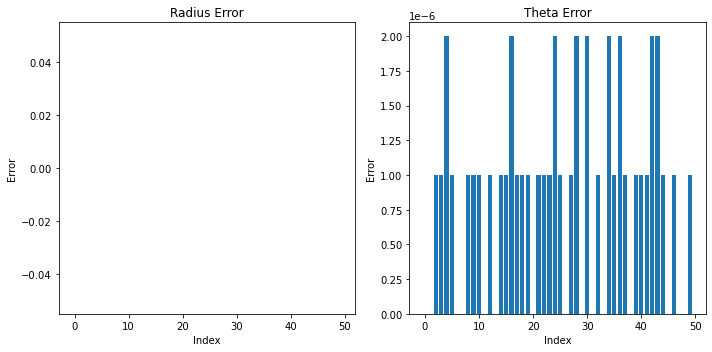

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,r_error)
plt.title("Radius Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,theta_error)
plt.title("Theta Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()